## 目的

LSTMに、サイン波を複数のGPUを使って学習させる。

## データ

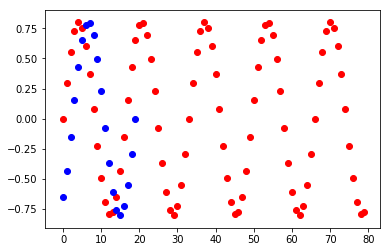

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import report, training, Chain, cuda, datasets, iterators, optimizers, Variable, function
from chainer.training import extensions
from chainer.datasets import tuple_dataset
import cupy
import six
# データ作成
N_data  = 1000
N_Loop  = 3
t = np.linspace(0., 2*np.pi*N_Loop, num=N_data)

X = 0.8*np.sin(2.0*t)

# データセット
N_train = int(N_data*0.8)
N_test  = int(N_data*0.2)

tmp_DataSet_X= np.array(X).astype(np.float32)

x_train, x_test = np.array(tmp_DataSet_X[:N_train]),np.array(tmp_DataSet_X[N_train:])

train = tuple_dataset.TupleDataset(x_train)
test  = tuple_dataset.TupleDataset(x_test)

plt.scatter(range(0,len(x_train)), x_train,c="red")
plt.scatter(range(0,len(x_test)), x_test, c="blue")
plt.show()

## Many2Many LSTM
ここで作るのは以下の図の5番目のLSTMである。

![](pics/diags.jpeg)

## Model
n_unitsは下記の図のxたちの次元を示す。

大きければ、大きいほど学習するパラメータの数が増える。

> each line carries an entire vector, from the output of one node to the inputs of others.

![](pics/LSTM3-chain.png)

In [197]:
class LSTM(Chain):
    n_input  = 1
    n_output = 1 
    n_units  = 5 #大きければ、大きいほど学習するパラメータの数が増える。

    def __init__(self):
        super(LSTM, self).__init__(
            l1 = L.Linear(self.n_input, self.n_units),
            l2 = L.LSTM(self.n_units, self.n_units),
            l3 = L.LSTM(self.n_units, self.n_units),
            l4 = L.LSTM(self.n_units, self.n_units),
            l5 = L.Linear(self.n_units, self.n_output),
        )

    def reset_state(self):
        self.l2.reset_state()

    def __call__(self, x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
        h4 = self.l4(h3)
        return self.l5(h4)

In [181]:
class LSTM_Iterator(chainer.dataset.Iterator):
    def __init__(self, dataset, batch_size = 1024, seq_len = 100, repeat = True):
        self.seq_length = seq_len
        self.dataset = dataset
        self.nsamples =  len(dataset)

        self.batch_size = batch_size
        self.repeat = repeat

        self.epoch = 0
        self.iteration = 0
        self.offsets = np.random.randint(0, len(dataset),size=batch_size)

        self.is_new_epoch = False

    def __next__(self):
        # Iterates through nsamples, batch_size chunks at each iteration
        if not self.repeat and self.iteration * self.batch_size >= self.nsamples:
            raise StopIteration
        
        x, t = self.get_data()
        self.iteration += 1

        epoch = int(self.epoch_detail)
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch
            # Returns batch_size dimensional array of random ints between 0 and nsamples
            self.offsets = np.random.randint(0, self.nsamples,size=self.batch_size)

        return list(zip(x, t))

    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / len(self.dataset)

    def get_data(self):
        # Get batch_size number of a tuple of a random x point and the following point as t
        x = [self.dataset[(offset + self.iteration)%self.nsamples][0]
               for offset in self.offsets]
        t = [self.dataset[(offset + self.iteration + 1)%self.nsamples][0]
               for offset in self.offsets]
        return x, t

    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch     = serializer('epoch', self.epoch)

In [182]:
class LSTM_std_updater(training.StandardUpdater):
    def __init__(self, train_iter, optimizer, device):
        super().__init__(train_iter, optimizer, device=device)
        self.seq_length = train_iter.seq_length

    def update_core(self):
        loss = 0

        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')

        for i in range(self.seq_length):
            batch = train_iter.__next__()
            x, t  = self.converter(batch, self.device)
            loss += optimizer.target(chainer.Variable(x.reshape((-1, 1))), chainer.Variable(t.reshape((-1, 1))))
        optimizer.target.zerograds()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()
        
class LSTM_prl_updater(training.ParallelUpdater):
    def __init__(self, train_iter, optimizer, devices):
        super().__init__(train_iter, optimizer, devices=devices)
        self.seq_length = train_iter.seq_length

    def update_core(self):
        losses = [0 for i in self._models]

        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')

        for i in range(self.seq_length):
            batch = train_iter.__next__()

            #ここから並列計算用の処理
            n = len(self._models)
            xt_list = {}
            for i, key in enumerate(six.iterkeys(self._models)):
                xt_list[key] = self.converter(
                    batch[i::n], self._devices[key])

            for model in six.itervalues(self._models):
                model.cleargrads()

            _losses = []
            for model_key, model in six.iteritems(self._models):
                x, t = xt_list[model_key]
                loss_func = self.loss_func or model

                with function.force_backprop_mode():
                    dev_id = self._devices[model_key]
                    dev_id = dev_id if 0 <= dev_id else None
                    with cuda.get_device_from_id(dev_id):
                        _loss = loss_func(x, t)
                        
                _losses.append(_loss)
        
        losses = [sum(x) for x in zip(losses, _losses)]
        optimizer.target.zerograds()
        for loss in losses:
            loss.backward()
            loss.unchain_backward()
        optimizer.update()

In [183]:
class LossFuncL(Chain):
    def __init__(self, predictor):
        super(LossFuncL, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        #ここの条件式、evalのときに呼ばれるx.dataだけなぜかメモリーなんだが、なぜか分かる人おしえて〜
        if (type(x.data)==memoryview or type(x.data)==cupy.cuda.MemoryPointer):
            x = Variable(x.reshape((-1, 1)))
            t = Variable(t.reshape((-1, 1)))

        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss}, self)
        return loss


In [184]:
def run_LSTM(
    epoch = 1000,
    gpu0 = -1,
    gpu1 = None,
    batchsize = 10,
    seqlen = 10,
):
    model = LossFuncL(LSTM() )
    optimizer = optimizers.Adam()
    optimizer.setup(model)
    
    train_iter = LSTM_Iterator(train, batch_size = batchsize, seq_len = seqlen)
    test_iter  = LSTM_Iterator(test,  batch_size = batchsize, seq_len = seqlen, repeat = False)

    if gpu1 is None:
        updater = LSTM_std_updater(
            train_iter, optimizer, device=gpu0)
    if gpu1 is not None:
        updater = LSTM_prl_updater(
            train_iter,
            optimizer,
            devices={'main': gpu0, 'second': gpu1},
        )

    trainer = training.Trainer(updater, (epoch, 'epoch'), out = 'result')

    eval_model = model.copy()
    eval_rnn = eval_model.predictor
    eval_rnn.train = False
    
    trainer.extend(extensions.Evaluator(test_iter, eval_model, device=gpu0),trigger=(10, 'epoch'))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        'epoch', file_name='loss.png', trigger=(10, 'epoch')
        ))

    trainer.extend(extensions.LogReport(),trigger=(epoch, 'epoch'))
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']),trigger=(epoch, 'epoch'))

    trainer.run()
    return model

In [189]:
def plot_test(model):
    model.to_cpu()
    presteps = 10
    poststeps = N_data - presteps
    model.predictor.reset_state()

    y_result = []

    for i in range(presteps):
        y = model.predictor(chainer.Variable(x_train[i].reshape((-1,1))))
        y_result.append(x_train[i])

    y_result.append(x_train[presteps])

    for i in range(poststeps-1):
        y = model.predictor(chainer.Variable(y.data))
        y_result.append(y.data)

    fig, axes = plt.subplots(figsize=(7,4))
    plt.plot(t, y_result)
    plt.plot(t, X)
    plt.show() 
    print("error: {0}".format(F.mean_squared_error(np.asarray(y_result), np.float32(X)).data))

epoch       main/loss   validation/main/loss  elapsed_time
10000       0.000899261  0.0874531             404.007       


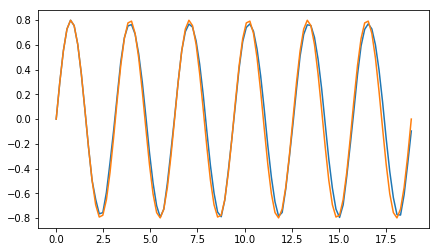

error: 0.005845481064170599
epoch       main/loss   validation/main/loss  elapsed_time
10000       0.00042296  0.0699434             570.19        


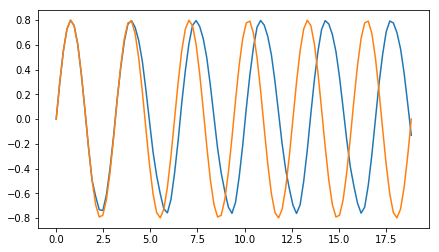

error: 0.47739800810813904
epoch       main/loss   validation/main/loss  elapsed_time
10000       0.000575419  0.181278              911.154       


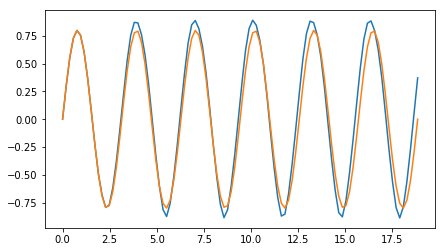

error: 0.016765575855970383


In [193]:
model_cpu = run_LSTM(gpu0=-1, batchsize=10, seqlen=10, epoch=10000)
plot_test(model_cpu)
model_1gpu = run_LSTM(gpu0=0,batchsize=10,seqlen=10, epoch=10000)
plot_test(model_1gpu)
model_2gpu = run_LSTM(gpu0=0,gpu1=1,batchsize=10,seqlen=10, epoch=10000)
plot_test(model_2gpu)